In [11]:

from DataExtraction.ExtractCMAQ import extractCMAQ, CMAQGridInfo, GCGridInfo, WRFGridInfo
from DataExtraction.ExtractOBS import extractOBS
from Evaluation.StatisticalMetrics import stats_metrics
from util.GeoProcess import StatePolygon, interest_domain_bound
from DataFusion.CMAQatOBS import CMAQatOBSDaily
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from Evaluation.StatisticalMetrics import MB, ME, RMSE, CRMSE, NMB, NME, MNB, MNE, FB, FE, IOA, pearson_r, monitor_stats_metrics, stats_metrics
from util.VisualizationFunc import plotPolygons, plotComparisonIntercept
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd

In [12]:
original_CMAQ_file = "/Volumes/DataStorage/DataFusionData/WRFChem/WRFChem_Combine_2017.nc"
obs_file = "/Volumes/DataStorage/DataFusionData/WRFChem/O3_obs_2017_CONUS_ppm.csv"
fused_CMAQ_file = "/Volumes/DataStorage/DataFusionData/fused/WRFChem_Combine_fused_2017_o3_no2.nc"
CMAQ_pollutant = "O3_MDA8"
obs_pollutant = "O3"
unit = "ppm"

geo = WRFGridInfo(original_CMAQ_file)
CMAQList = extractCMAQ(CMAQ_pollutant, original_CMAQ_file, geo)
OBSList = extractOBS(obs_pollutant, obs_file, geo)
fused_CMAQ_List = extractCMAQ(CMAQ_pollutant, fused_CMAQ_file, geo)

# define metrics dict
metrics_dict = {
    "MB": {"func": MB, "vals": []},
    "ME": {"func": ME, "vals": []},
    "RMSE": {"func": RMSE, "vals": []},
    "CRMSE": {"func": CRMSE, "vals": []},
    "NMB": {"func": NMB, "vals": []},
    "NME": {"func": NME, "vals": []},
    "MNB": {"func": MNB, "vals": []},
    "MNE": {"func": MNE, "vals": []},
    "FB": {"func": FB, "vals": []},
    "FE": {"func": FE, "vals": []},
    "IOA": {"func": IOA, "vals": []},
    "Pearson R": {"func": pearson_r, "vals": []}
}

In [13]:
states = [
    'Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 
    'Delaware', 'Florida', 'Georgia', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 
    'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 
    'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 
    'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 
    'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 
    'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 
    'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 
    'West Virginia', 'Wisconsin', 'Wyoming', 'District of Columbia'
]
state_polygons = [StatePolygon(state) for state in states]
lon_min, lon_max, lat_min, lat_max = interest_domain_bound(state_polygons)

## Correlation of Each Monitors

In [14]:
combined_CMAQ_dict = CMAQList[0]
combined_obs_dict = OBSList[0]
fused_CMAQ_dict = fused_CMAQ_List[0]
model_performance = monitor_stats_metrics(combined_CMAQ_dict, combined_obs_dict, geo, metrics_dict)
fused_model_performance = monitor_stats_metrics(fused_CMAQ_dict, combined_obs_dict, geo, metrics_dict)

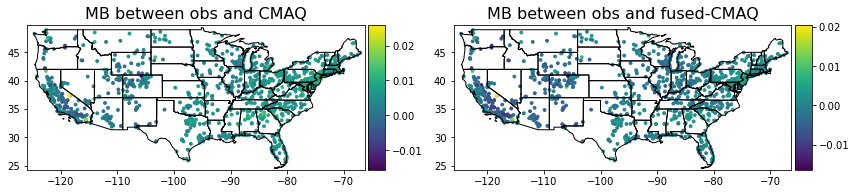

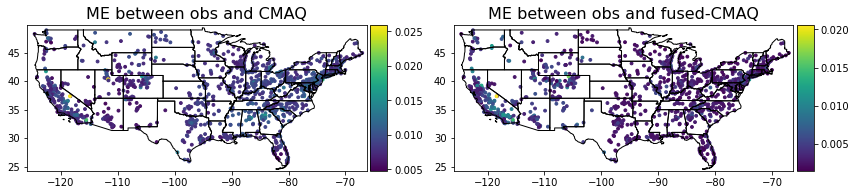

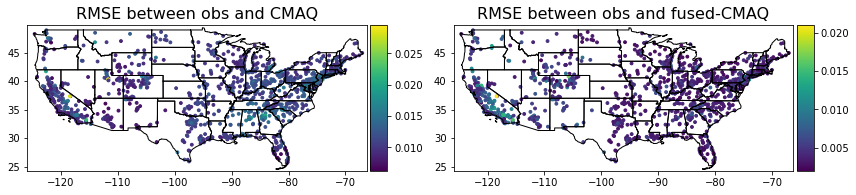

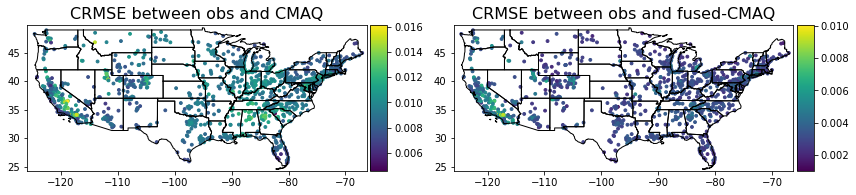

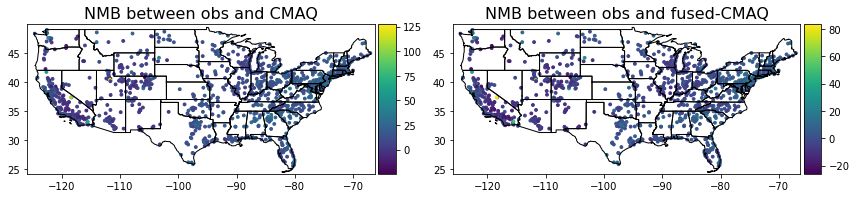

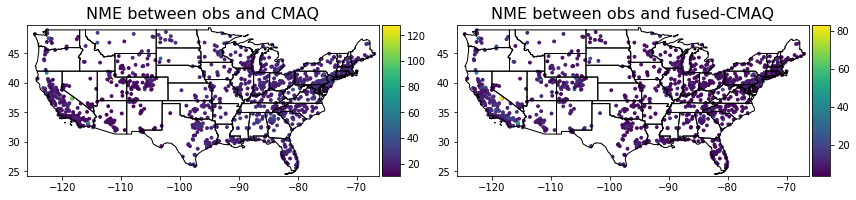

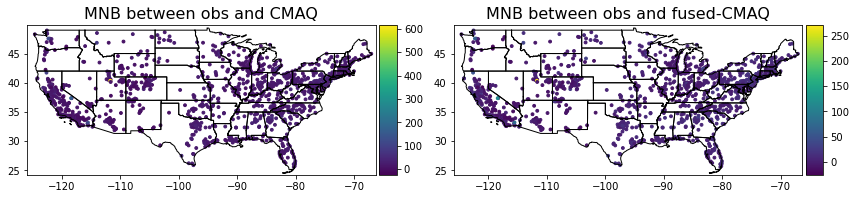

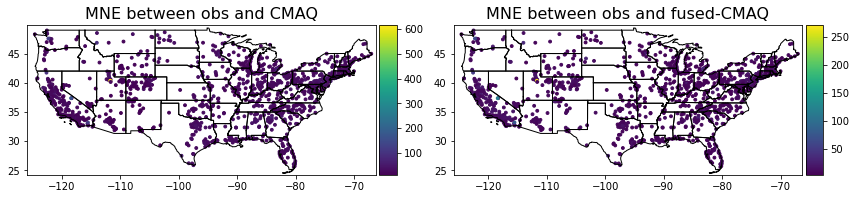

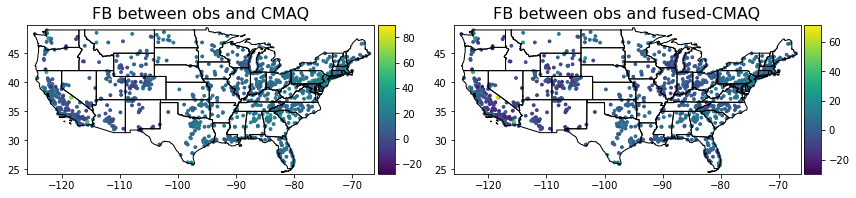

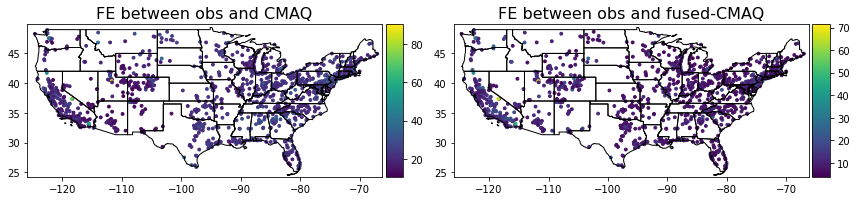

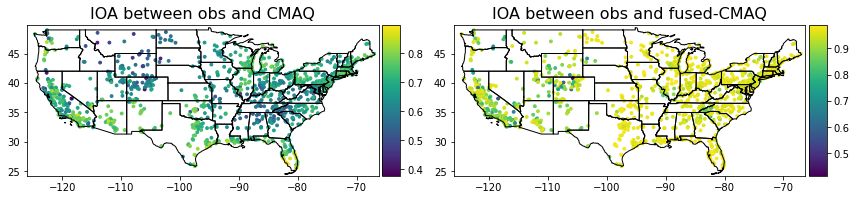

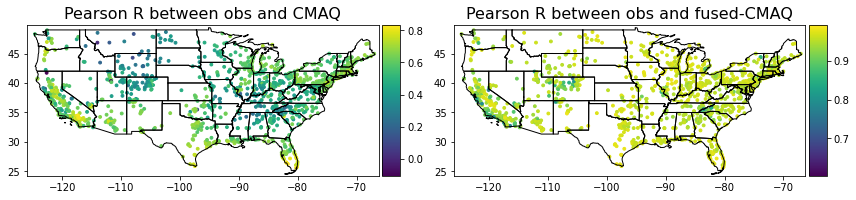

In [15]:
for metric in metrics_dict.keys():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    # model
    plotPolygons(state_polygons, ax1, 'black')
    c = ax1.scatter(model_performance["Lon"], model_performance["Lat"], c=model_performance[metric], s=8)
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb = fig.colorbar(c, cax=cax, orientation='vertical')
    ax1.set_aspect('equal', adjustable='box')
    ax1.set_title("%s between obs and CMAQ" % metric, fontsize=16)
    ax1.set_xlim(lon_min, lon_max)
    ax1.set_ylim(lat_min, lat_max)
    # Fused
    plotPolygons(state_polygons, ax2, 'black')
    c = ax2.scatter(fused_model_performance["Lon"], fused_model_performance["Lat"], c=fused_model_performance[metric], s=8)
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb = fig.colorbar(c, cax=cax, orientation='vertical')
    ax2.set_aspect('equal', adjustable='box')
    ax2.set_title("%s between obs and fused-CMAQ" % metric, fontsize=16)
    ax2.set_xlim(lon_min, lon_max)
    ax2.set_ylim(lat_min, lat_max)
    plt.tight_layout()

## Overall Performance

In [16]:
model_performance, model_vals, obs_vals = stats_metrics(combined_CMAQ_dict, combined_obs_dict, geo, metrics_dict)
fused_model_performance, f_model_vals, f_obs_vals = stats_metrics(fused_CMAQ_dict, combined_obs_dict, geo, metrics_dict)

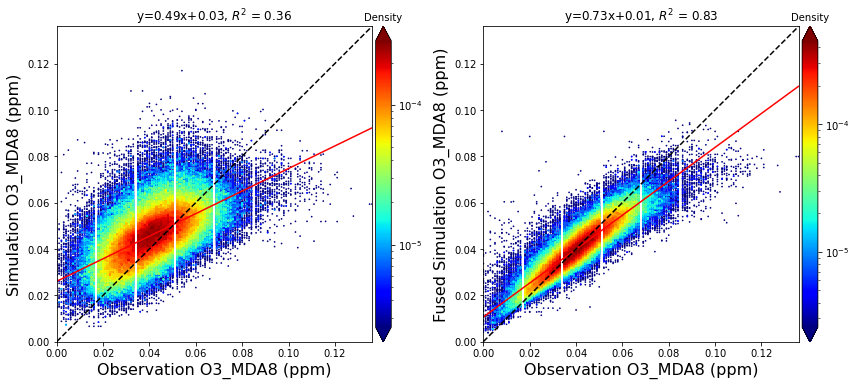

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
txt_1 = plotComparisonIntercept(obs_vals, model_vals, 1000, ax1, fig)
ax1.set_xlabel("Observation %s (%s)" % (CMAQ_pollutant, unit), fontsize=16)
ax1.set_ylabel("Simulation %s (%s)" % (CMAQ_pollutant, unit), fontsize=16)
max_val = np.max([np.max(obs_vals), np.max(model_vals)])
ax1.set_aspect('equal', adjustable='box')
ax1.plot([0, max_val], [0, max_val], 'k--')
ax1.set_xlim([0, max_val])
ax1.set_ylim([0, max_val])
ax1.set_title(txt_1)

txt_2 = plotComparisonIntercept(f_obs_vals, f_model_vals, 1000, ax2, fig)
ax2.set_xlabel("Observation %s (%s)" % (CMAQ_pollutant, unit), fontsize=16)
ax2.set_ylabel("Fused Simulation %s (%s)" % (CMAQ_pollutant, unit), fontsize=16)
max_val = np.max([np.max(f_obs_vals), np.max(f_model_vals)])
ax2.set_xlim([0, max_val])
ax2.set_ylim([0, max_val])
ax2.set_aspect('equal', adjustable='box')
ax2.plot([0, max_val], [0, max_val], 'k--')
ax2.set_title(txt_2)
plt.tight_layout()
plt.show()

In [18]:
model_df = pd.DataFrame.from_dict(model_performance)
fused_model_df = pd.DataFrame.from_dict(fused_model_performance)

In [19]:
display(model_df)

,metrics,values
0,MB,0.004907
1,ME,0.008755
2,RMSE,0.011343
3,CRMSE,0.010227
4,NMB,11.921464
5,NME,21.272270
6,MNB,20.211581
7,MNE,27.508797
8,FB,13.421564
9,FE,21.533514


In [20]:
display(fused_model_df)

,metrics,values
0,MB,-0.000397
1,ME,0.003893
2,RMSE,0.005298
3,CRMSE,0.005283
4,NMB,-0.963690
5,NME,9.457865
6,MNB,2.379407
7,MNE,10.980673
8,FB,0.876560
9,FE,10.068651
